In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yanhu/data/PRINT/multiScaleFootprinting/code")
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import time
import torch
import pickle
from scipy.stats import *
from tqdm.auto import *
import pyBigWig
import re
import copy

In [2]:
model_dir = '/home/yanhu/data/PRINT/multiScaleFootprinting/data/HepG2/final_model'
peaks_path = '/home/yanhu/data/PRINT/multiScaleFootprinting/data/HepG2/peaks.bed'
TFBS_path = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/HepG2/TF_prediction.tsv"
plot_dir = '/home/yanhu/data/PRINT/multiScaleFootprinting/data/HepG2/plots'
models_path = ['HepG2_fold0-crimson-bao-8.pt',
'HepG2_fold1-auspicious-rocket-9.pt',
'HepG2_fold2-prosperous-fish-8.pt',
'HepG2_fold3-prosperous-bao-11.pt',
'HepG2_fold4-radiant-paper-12.pt']
printer_path = '/home/yanhu/data/PRINT/multiScaleFootprinting/data/HepG2/HepG2_scprinter.h5ad'

In [3]:
# Load genomic ranges of ATAC-peaks 
peaks = pd.read_csv(peaks_path, sep='\t', header=None)
peaks.head()

0       1       2
0  chr1  827026  828026
1  chr1  857897  858897
2  chr1  860538  861538
3  chr1  869441  870441
4  chr1  876235  877235

In [4]:
# Load previously-trained sequence-to-footprint models
models = [torch.load(os.path.join(model_dir, m), map_location='cpu') for m in models_path]
for m in models:
    m.eval()

In [5]:
# Load scPrinter object
printer = scp.load_printer(printer_path, scp.genome.hg38)

Initializing GFF-db


## Subfigure - 1: Global similarity

### Compare predicted versus observed and calculate correlation

In [6]:
# global measurement: pearsonr between pred vs footprint/coverage
# Let's do a subsample of the peak file, let's say 10000 to reduce time and storage
subset_peak = peaks.sample(10000)
scp.tl.get_footprint_score(printer=printer,
                           cell_grouping = printer.insertion_file.obs_names,
                           group_names = 'HepG2',
                           regions = subset_peak,
                           nCores = 32,
                           backed = False,
                           overwrite = True)

estimated file size: 3.67 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160
Insertion profile from csr to csc


Submitting jobs:   0%|          | 0/990000 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/990000 [00:00<?, ?it/s]

In [8]:
summit_keys = [f'{chr}:{s}-{e}' for chr,s,e in zip(subset_peak.iloc[:, 0], subset_peak.iloc[:, 1], subset_peak.iloc[:, 2])]
gt_footprints = np.array([printer.footprintsadata['FootPrints'].obsm[k] for k in summit_keys])
gt_footprints = gt_footprints[:, 0, :, 100:-100]
gt_footprints.shape

(10000, 99, 800)

In [9]:
from functools import partial 
# Let's get the coverage
scp.tl.get_insertions(printer=printer,
                      cell_grouping = printer.insertion_file.obs_names,
                       group_names = 'HepG2',
                       regions = subset_peak,
                        backed=False,
                        overwrite= True,
                        summarize_func=partial(np.sum, axis=-1))

Creating Insertions in printer.insertionadata
obs=groups, var=regions


  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
gt_coverage = np.array([printer.insertionadata['Insertions'].obsm[k] for k in summit_keys])
gt_coverage.shape

(10000, 1)

In [11]:
pred_footprints_avg = 0
pred_coverage_avg = 0
with torch.no_grad():
    for model in models:
        model = model.cuda()
        flank = 920
        # Now from model predictions
        chroms, starts, ends = np.array(subset_peak.iloc[:, 0]), np.array(subset_peak.iloc[:, 1]), np.array(subset_peak.iloc[:, 2])
        results = [[], []]
        for i in trange(len(subset_peak)):
            chr, s, e = chroms[i], starts[i], ends[i]
            center = (s + e) // 2
            seq = scp.genome.hg38.fetch_seq(chr, 
                                                   center-flank, 
                                                   center+flank)
            seq = scp.utils.DNA_one_hot(seq)[None].float().cuda()
            pred_footprint, pred_coverage = model(seq)
            results[0].append(pred_footprint.detach().cpu().numpy())
            results[1].append(pred_coverage.detach().cpu().numpy())
        pred_footprints_avg += np.array(results[0])
        pred_coverage_avg += np.array(results[1])
        model = model.cpu()
pred_footprints_avg /= len(models)
pred_coverage_avg /= len(models)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
pred_footprints_avg = scp.utils.zscore2pval(pred_footprints_avg[:, 0, :, :])

In [14]:
pickle.dump([
    subset_peak,
    gt_footprints,
    gt_coverage,
    pred_footprints_avg,
    pred_coverage, 
], open(os.path.join(model_dir, "Fig2_data1.pkl"), "wb"))

## Subfigure - 1: Global similarity (visualization)

In [6]:
subset_peak, gt_footprints, gt_coverage, pred_footprints_avg, pred_coverage = pickle.load(open(os.path.join(model_dir, "Fig2_data1.pkl"), "rb"))

In [7]:
gt_footprints[gt_footprints > 20] = 20
pred_footprints_avg[pred_footprints_avg > 20] = 20

In [14]:
pearson_within = [pearsonr(x.reshape((-1)), y.reshape((-1)))[0] for x,y in zip(tqdm(gt_footprints), pred_footprints_avg)]

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_652237/945249321.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pearson_within)


<Axes: ylabel='Density'>

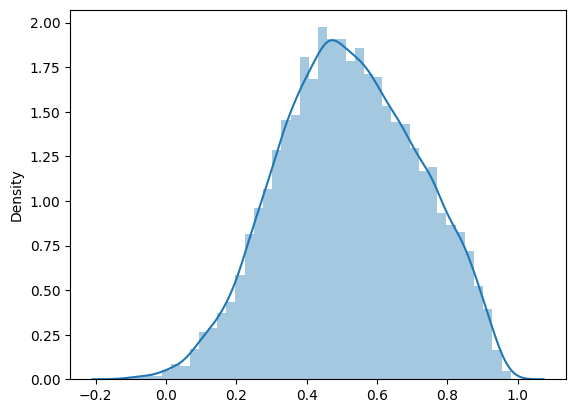

In [15]:
sns.distplot(pearson_within)

Text(0.5, 1.0, 'Footprints R=PearsonRResult(statistic=0.6358836693810788, pvalue=0.0)')

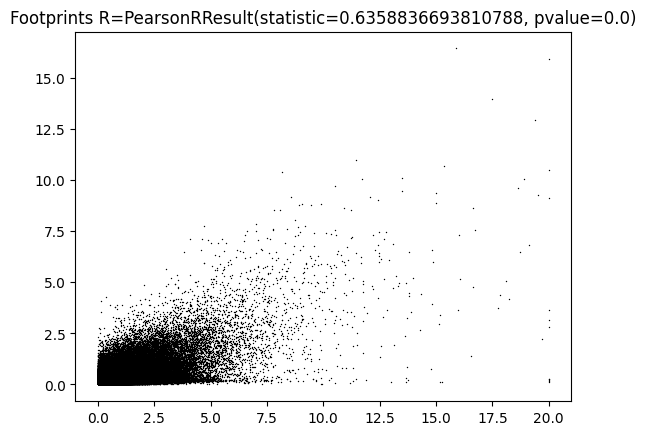

In [16]:
pearson_general = pearsonr(gt_footprints.reshape((-1)), pred_footprints_avg.reshape((-1)))
# drawn random id to save time
random_id = np.random.permutation(np.prod(gt_footprints.shape))[:1000000]
sns.scatterplot(x=gt_footprints.reshape((-1))[random_id], y=pred_footprints_avg.reshape((-1))[random_id], linewidth=0, s=1, c='black')
plt.title(f"Footprints R={pearson_general}")

In [17]:
pearson_cov = pearsonr(np.log1p(gt_coverage).reshape((-1)),np.log1p(pred_coverage_avg).reshape((-1)))
sns.scatterplot(x=np.log1p(gt_coverage).reshape((-1)), y=np.log1p(pred_coverage_avg).reshape((-1)), linewidth=0, s=1, c='black')
plt.title(f"Coverage R={pearson_cov}")

NameError: name 'pred_coverage_avg' is not defined

## Subfigure -2: case study, pick some regions and visualize with multi-scale attributions

### Selecte regions to visualize

In [6]:
subset_peak, gt_footprints, gt_coverage, pred_footprints_avg, pred_coverage = pickle.load(open(os.path.join(model_dir, "Fig2_data1.pkl"), "rb"))
pearson_within = [pearsonr(x.reshape((-1)), y.reshape((-1)))[0] for x,y in zip(tqdm(gt_footprints), pred_footprints_avg)]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
# Let's also pick regions, where it has high pearson and low pearson
high = np.where(pearson_within > np.quantile(pearson_within, 0.9))[0]
high = np.random.permutation(high)[:10]
low = np.where(pearson_within < np.quantile(pearson_within, 0.1))[0]
low = np.random.permutation(low)[:10]

In [8]:
# Randomly sample 10 regions
random_peak = peaks.sample(10)
chrs = list(random_peak.iloc[:, 0]) + list(subset_peak.iloc[high, 0]) + list(subset_peak.iloc[low, 0])
starts = list(random_peak.iloc[:, 1]) + list(subset_peak.iloc[high, 1]) + list(subset_peak.iloc[low, 1])
ends = list(random_peak.iloc[:, 2]) + list(subset_peak.iloc[high, 2]) + list(subset_peak.iloc[low, 2])

In [9]:
# Add additional example regions
chrs += ['chr6', 'chr4']
starts += [154732871, 39181839]
ends += [154733871, 39182839]

### Compute predicted footpirnts for sampled regions

In [10]:
# Get model-predictdd multi-scale footprints for the sampled regions
pred_footprints_avg = 0
pred_coverage_avg = 0
with torch.no_grad():
    for model in models:
        model = model.cuda()
        flank = 920
        # Now from model predictions
        results = [[], []]
        for i in trange(len(chrs)):
            chr, s, e = chrs[i], starts[i], ends[i]
            center = (s + e) // 2
            seq = scp.genome.hg38.fetch_seq(chr, 
                                                   center-flank, 
                                                   center+flank)
            seq = scp.utils.DNA_one_hot(seq)[None].float().cuda()
            pred_footprint, pred_coverage = model(seq)
            results[0].append(pred_footprint.detach().cpu().numpy())
            results[1].append(pred_coverage.detach().cpu().numpy())
        pred_footprints_avg += np.array(results[0])
        pred_coverage_avg += np.array(results[1])
        model = model.cpu()
pred_footprints_avg /= len(models)
pred_coverage_avg /= len(models)
pred_footprints_avg = scp.utils.zscore2pval(pred_footprints_avg[:, 0, :, :])

  0%|          | 0/32 [00:00<?, ?it/s]

/home/yanhu/utils/miniforge3/envs/print/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Compute observed footpirnts for sampled regions

In [11]:
# Calculate multi-scale footprints for the sampled regions
summit_keys = [f'{chr}:{s}-{e}' for chr,s,e in zip(chrs, starts, ends)]
scp.tl.get_footprint_score(printer=printer,
                           cell_grouping = printer.insertion_file.obs_names,
                           group_names = 'HepG2',
                           regions = summit_keys,
                           nCores = 16,
                           backed = False,
                           overwrite = True)
gt_footprints = np.array([printer.footprintsadata['FootPrints'].obsm[k] for k in summit_keys])
gt_footprints = gt_footprints[:, 0, :, 100:-100]
gt_footprints.shape

estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160
Insertion profile from csr to csc


Submitting jobs:   0%|          | 0/3168 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/3168 [00:00<?, ?it/s]

(32, 99, 800)

### Compute sequence attribution scores for sampled regions

In [12]:
# Get sequence attribution scores. 
seq_attrs = 0
for model in models_path:
    bw = os.path.join(model_dir, model+"_deepshap", "attr.just_sum.shap_hypo_0-30_.None.bigwig")
    bw = pyBigWig.open(bw, 'r')
    vs = []
    for chr,s,e in zip(chrs, starts, ends):
        vs.append(bw.values(chr, s+100, e-100, numpy=True))
    vs = np.array(vs)
    seq_attrs += vs
seq_attrs = seq_attrs / len(models)
seq_attrs.shape

(32, 800)

In [13]:
one_hot_encoding = []
for chr,s,e in zip(chrs, starts, ends):
    chr, s, e = chrs[i], starts[i], ends[i]
    center = (s+e) // 2
    seq = scp.genome.hg38.fetch_seq(chr, center-400, center+400)
    seq = scp.utils.DNA_one_hot(seq).cpu().numpy()
    one_hot_encoding.append(seq)
one_hot_encoding = np.array(one_hot_encoding)

### Quick visualization of all selected regions

  0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_1366862/2337433440.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1)


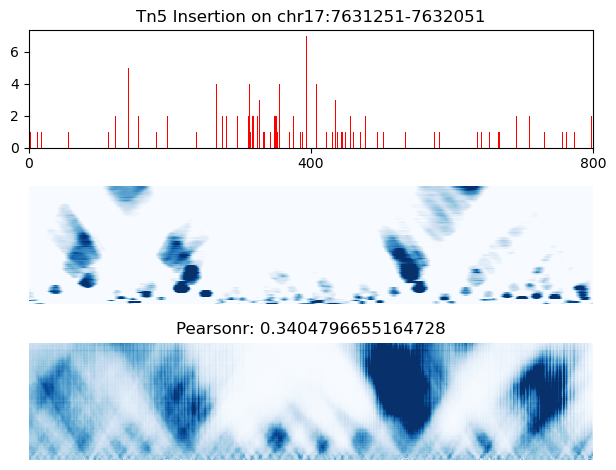

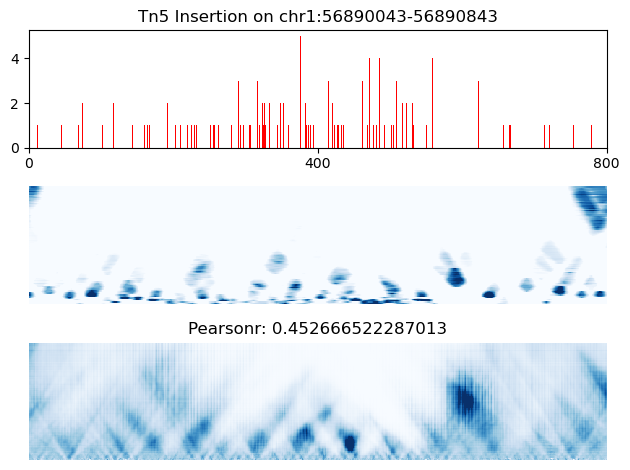

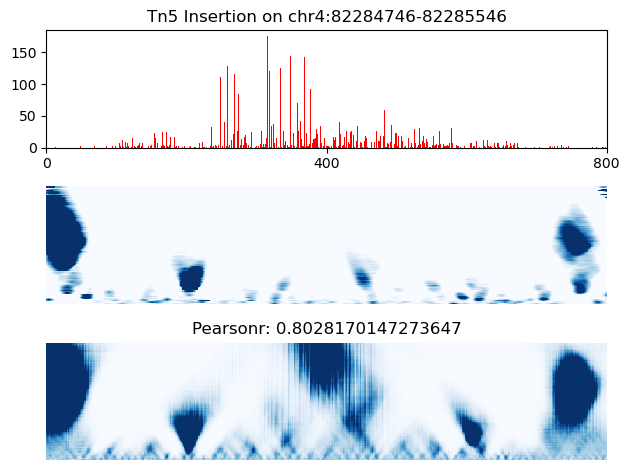

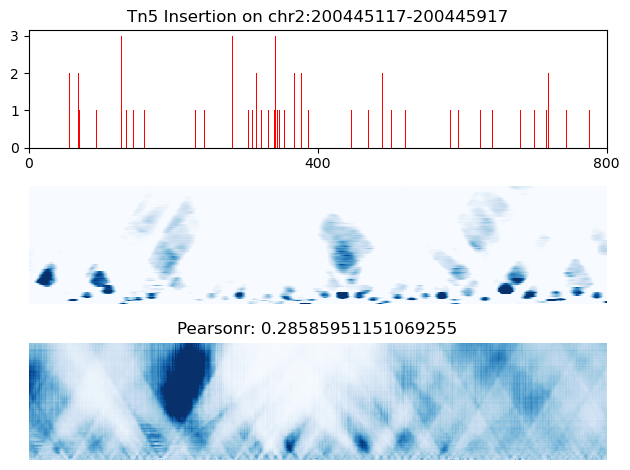

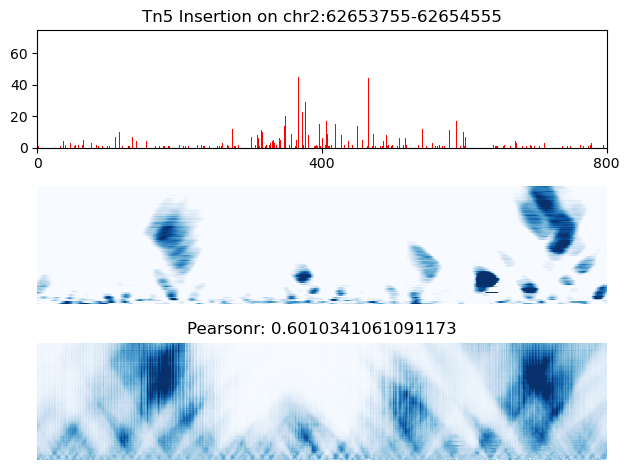

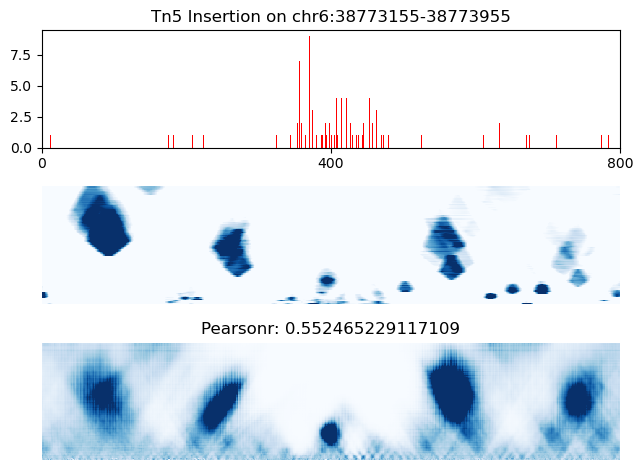

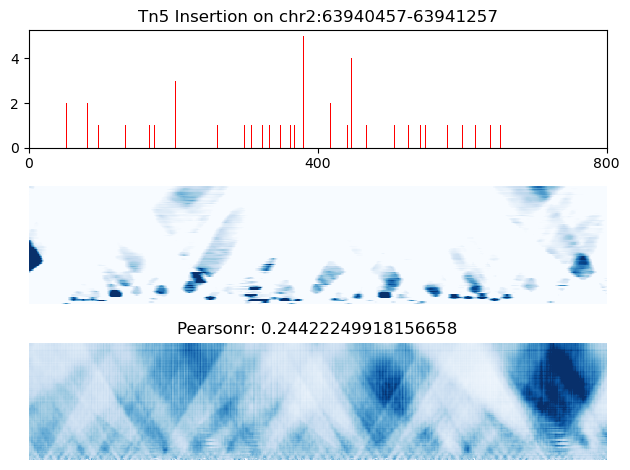

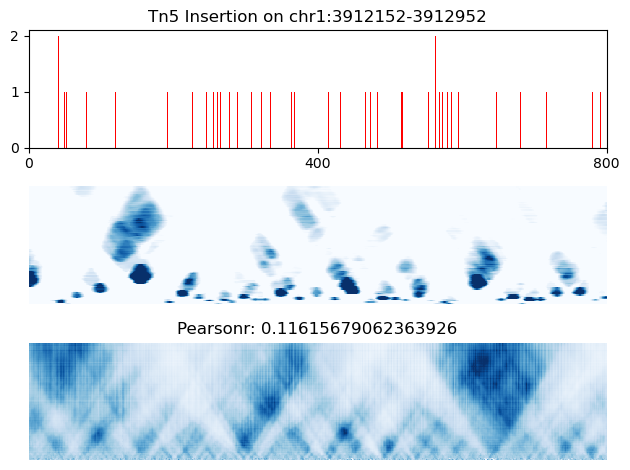

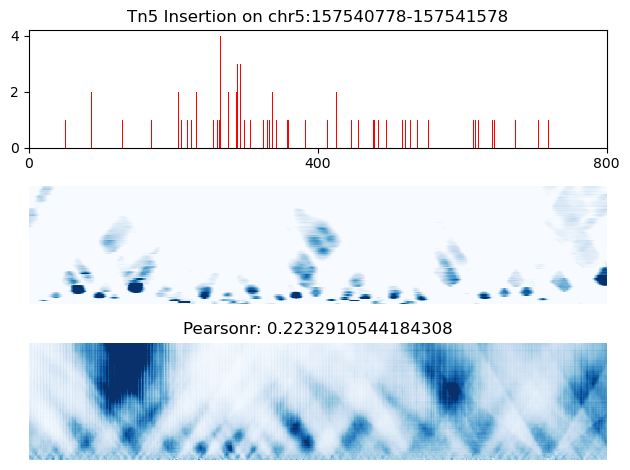

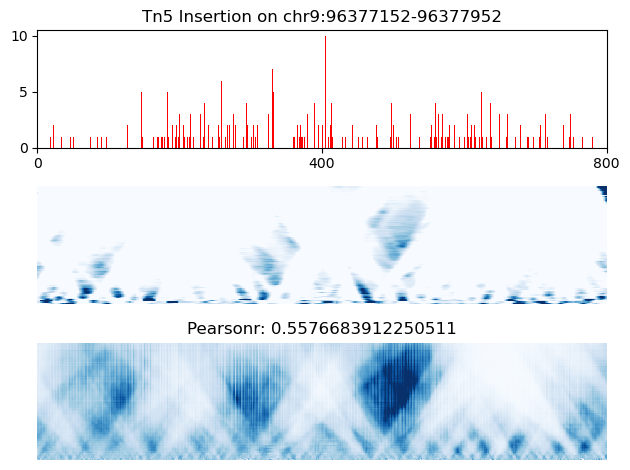

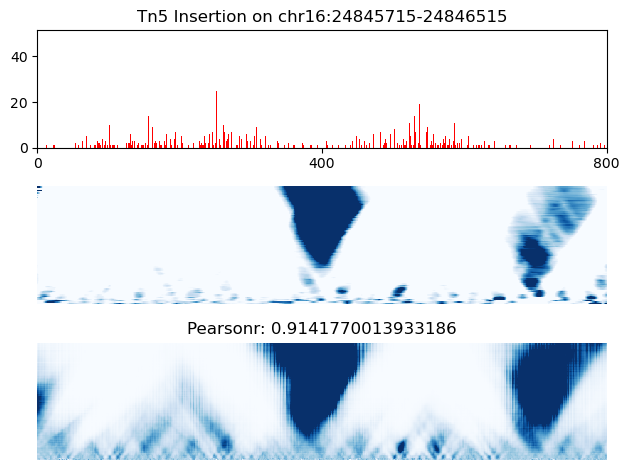

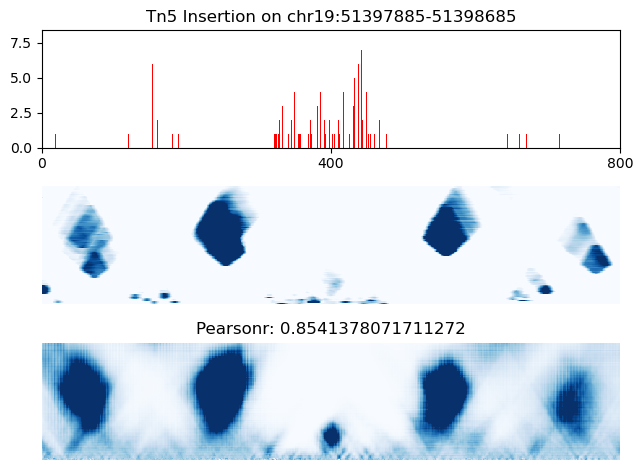

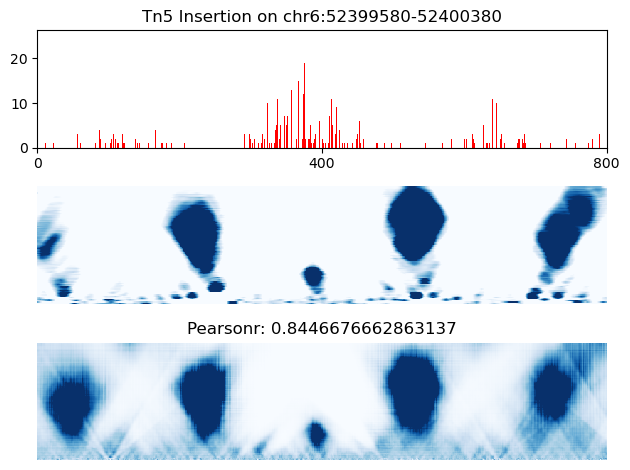

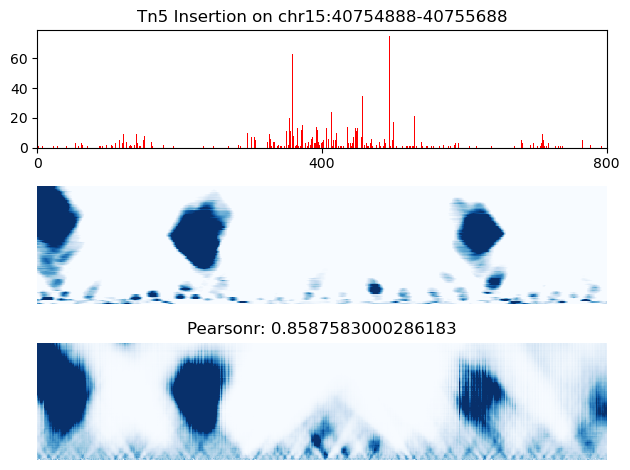

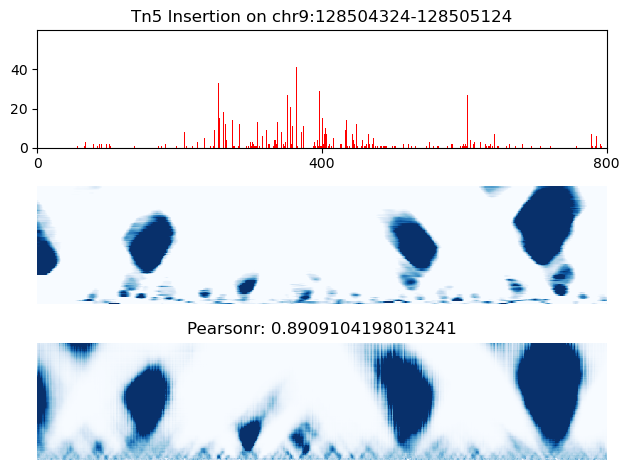

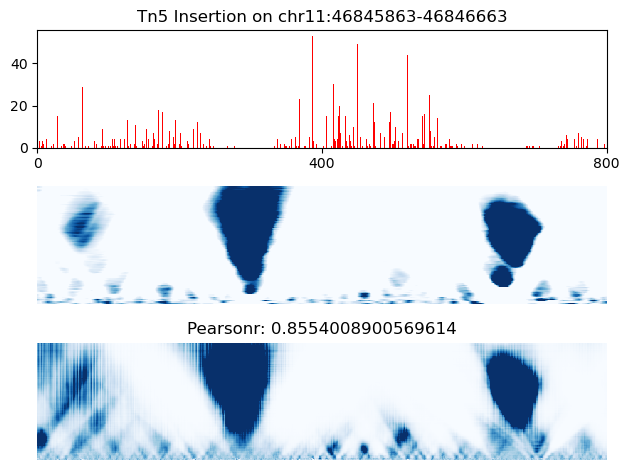

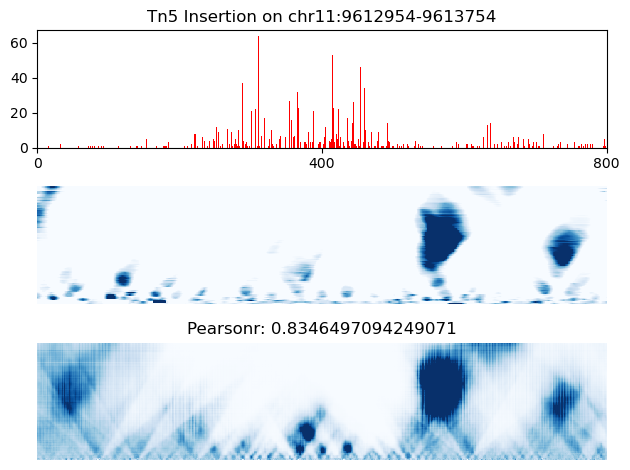

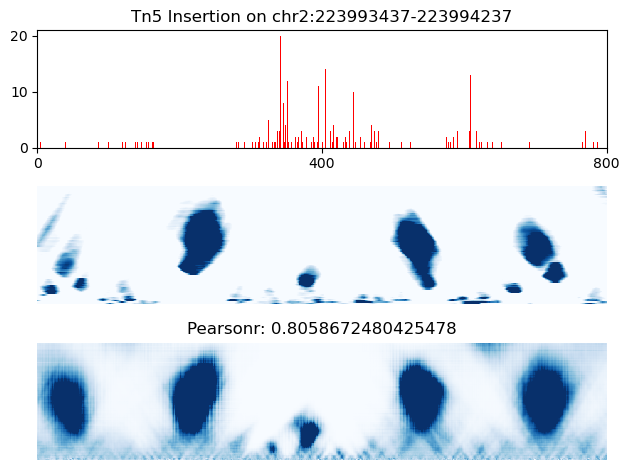

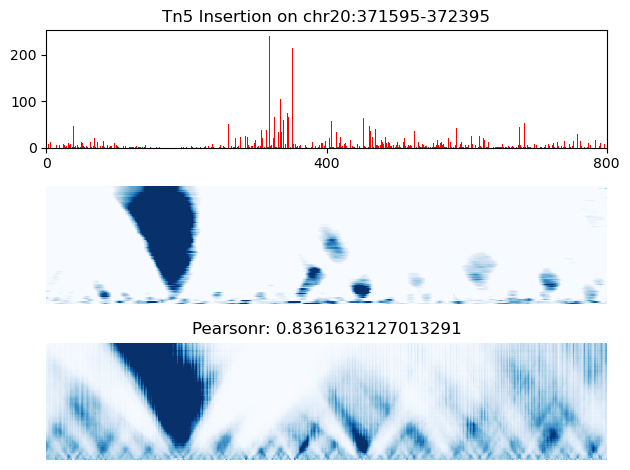

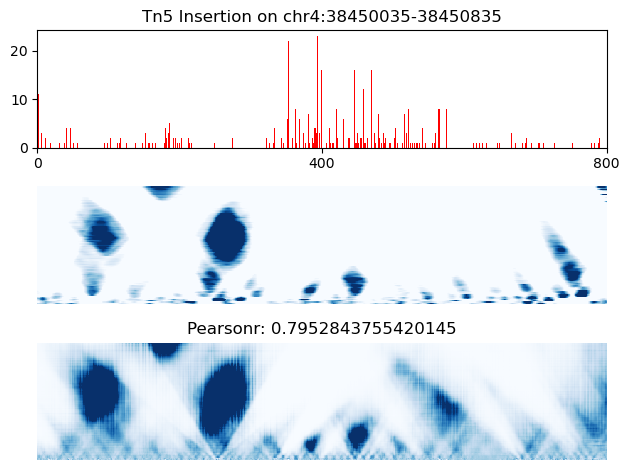

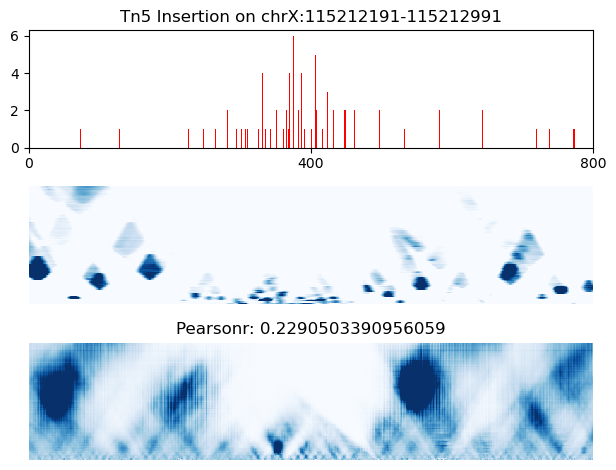

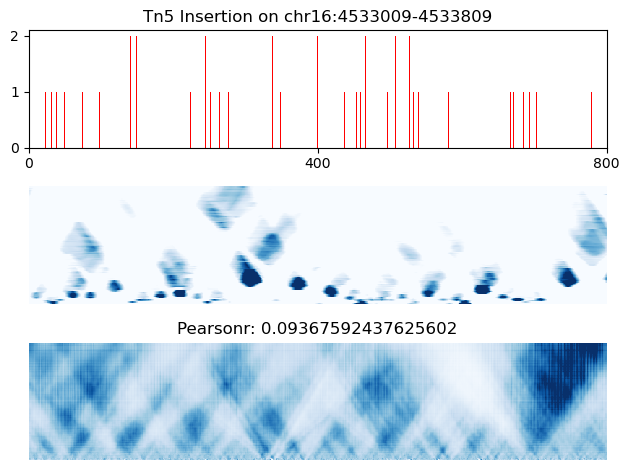

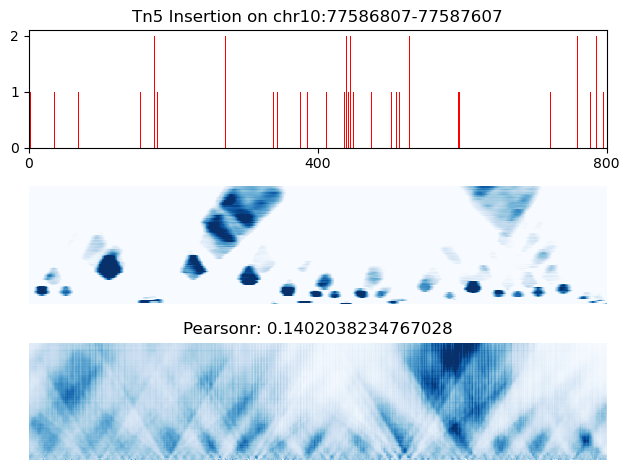

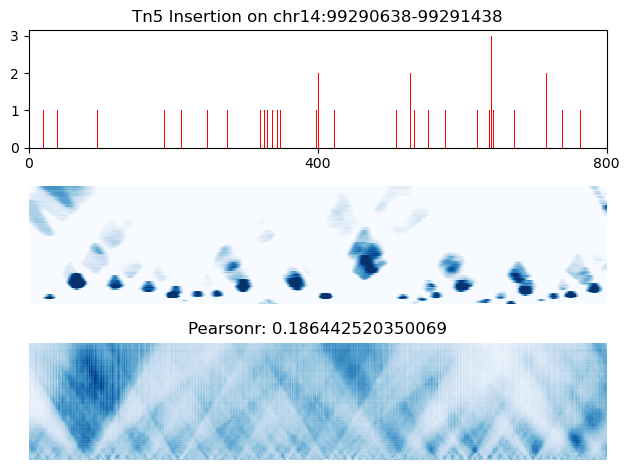

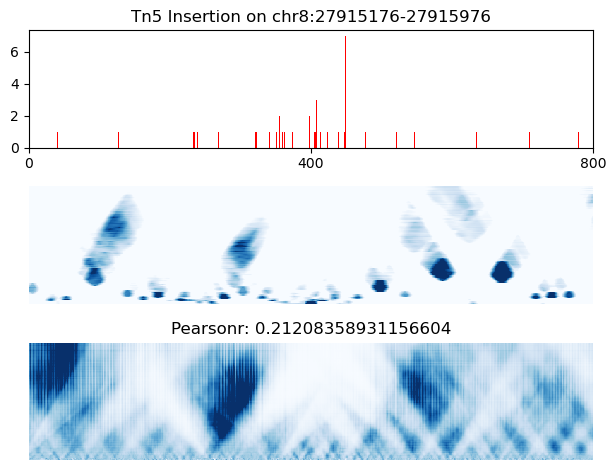

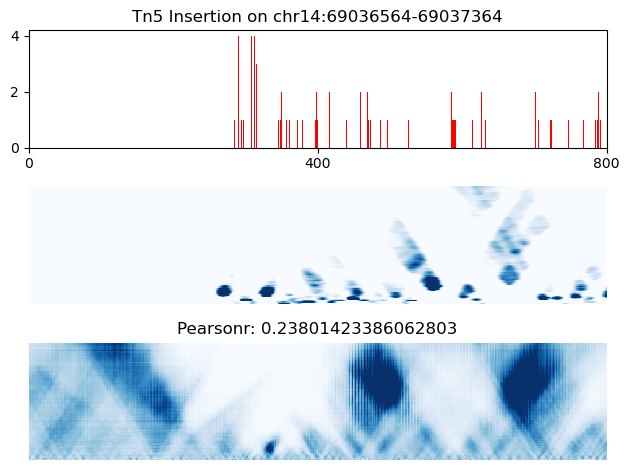

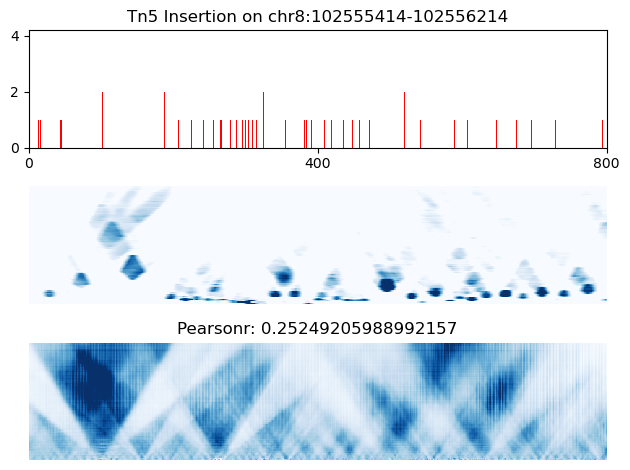

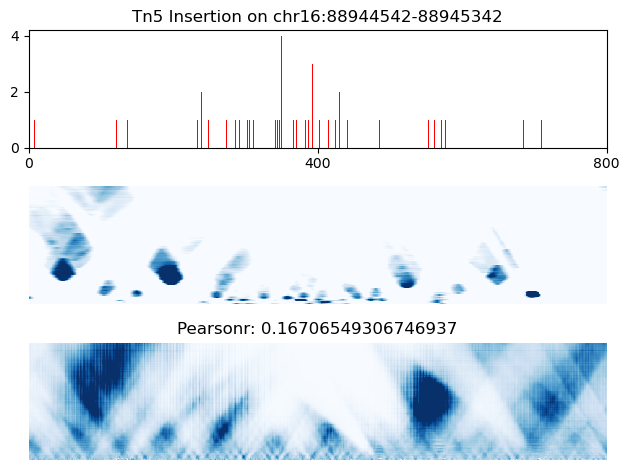

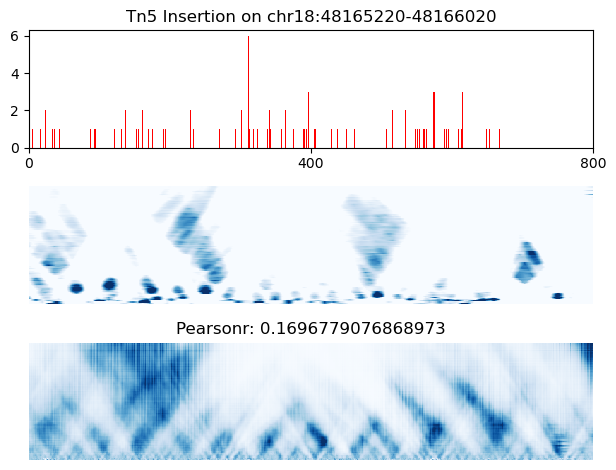

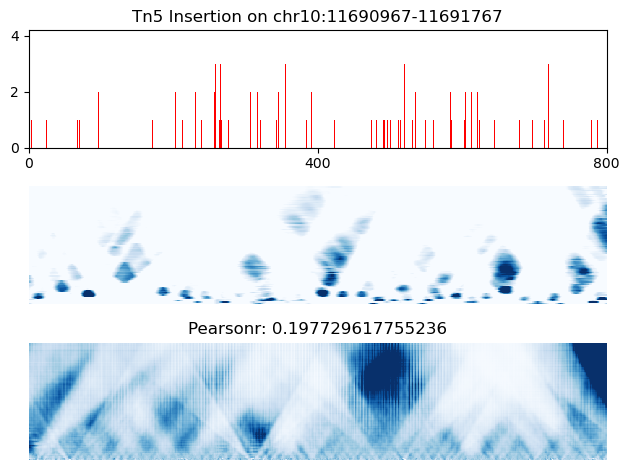

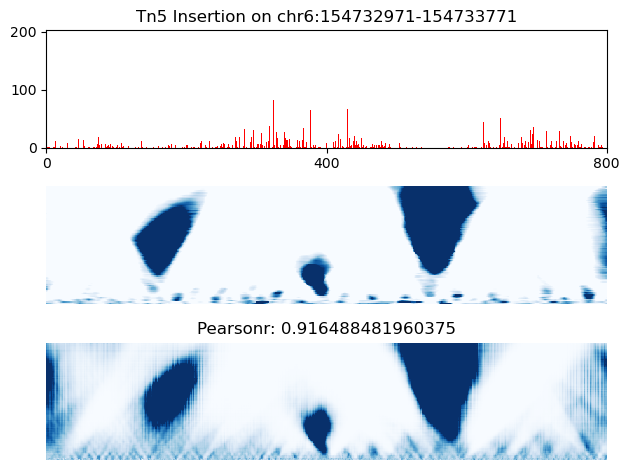

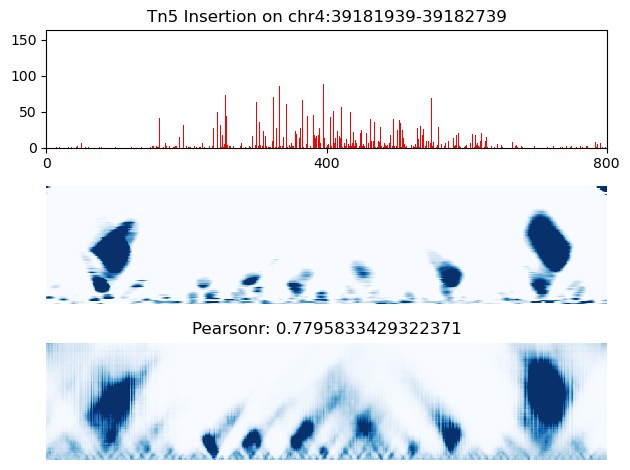

In [14]:
for i in trange(len(chrs)):
    chr, s, e = chrs[i], starts[i], ends[i]
    center = (s+e) // 2
    title = f'{chr}:{center-400}-{center+400}'
    fig, axs = plt.subplots(3, 1)
    axs = list(axs)
    scp.pl.plot_group_atac(printer,
                           printer.insertion_file.obs_names,
                           'HepG2',
                           title,
                           ax=axs[0],
                           color="red", legend=False)
    
    sns.heatmap(gt_footprints[i][::-1], cmap='Blues', vmin=0.5, vmax=2.0, ax=axs[1], cbar=False)
    axs[1].axis('off')
    sns.heatmap(pred_footprints_avg[i][::-1], cmap='Blues', vmin=0.0, vmax=0.5, ax=axs[2], cbar=False)
    r = pearsonr(gt_footprints[i].reshape((-1)), pred_footprints_avg[i].reshape((-1)))[0]
    axs[2].axis('off')
    axs[2].set_title(f'Pearsonr: {r}')
    plt.tight_layout()
    # plt.close('all')
    # break

### Now selecte a single region we are interested in and make visualizations

In [15]:
# Select region
example_ind = 31
region_id = "_".join([chrs[example_ind], str(starts[example_ind]), str(ends[example_ind])])

2024-02-27 10:05:43 - INFO - maxp pruned
2024-02-27 10:05:43 - INFO - cmap pruned
2024-02-27 10:05:43 - INFO - kern dropped
2024-02-27 10:05:43 - INFO - post pruned
2024-02-27 10:05:43 - INFO - FFTM dropped
2024-02-27 10:05:43 - INFO - GPOS pruned
2024-02-27 10:05:43 - INFO - GSUB pruned
2024-02-27 10:05:43 - INFO - glyf pruned
2024-02-27 10:05:43 - INFO - Added gid0 to subset
2024-02-27 10:05:43 - INFO - Added first four glyphs to subset
2024-02-27 10:05:43 - INFO - Closing glyph list over 'GSUB': 10 glyphs before
2024-02-27 10:05:43 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nonmarkingreturn', 'space', 'two', 'zero']
2024-02-27 10:05:43 - INFO - Glyph IDs:   [0, 1, 2, 3, 19, 21, 23, 24, 27, 3228]
2024-02-27 10:05:43 - INFO - Closed glyph list over 'GSUB': 10 glyphs after
2024-02-27 10:05:43 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nonmarkingreturn', 'space', 'two', 'zero']
2024-02-27 10:05:43 - INFO - Glyph IDs: 

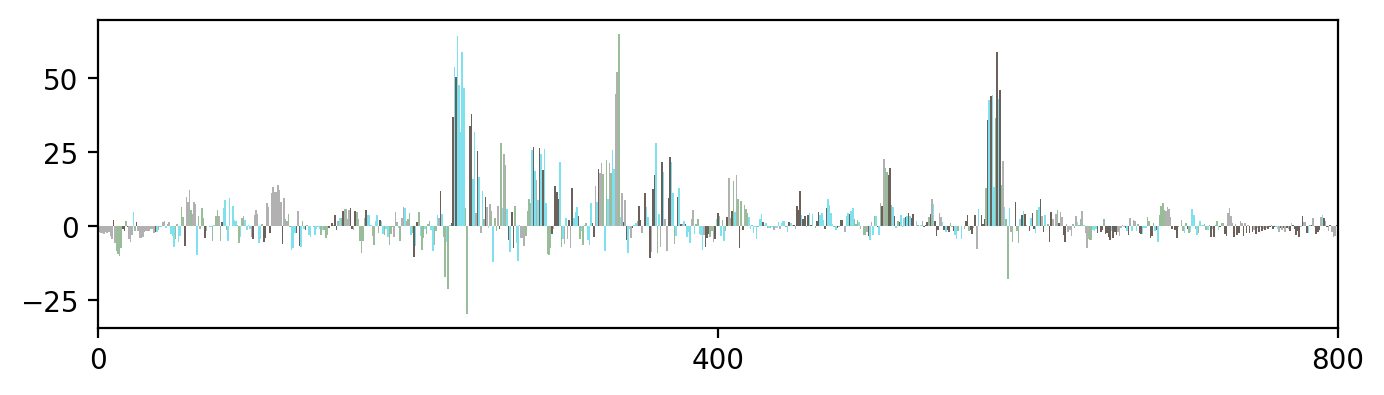

In [16]:
# Plot sequence attribution score for the whole region
fig, ax_ = plt.subplots(dpi = 200, figsize = (8, 2))
attr = seq_attrs[example_ind]
seq_onehot = one_hot_encoding[example_ind]
x = np.arange(len(attr))
color = [["#b2b1b1", "#7fe0ee", "#6b615a", "#99bd98"][i] for i in np.argmax(seq_onehot, axis=0)]
ax_.bar(x=x, height=attr, width=1,color=color)
ax_.set_xticks([0, int(0.5 * attr.shape[-1]), attr.shape[-1]])
ax_.set_xlim(0, attr.shape[-1])
plt.savefig(os.path.join(plot_dir, region_id + "_attribution_score_track.pdf"), dpi = 200)

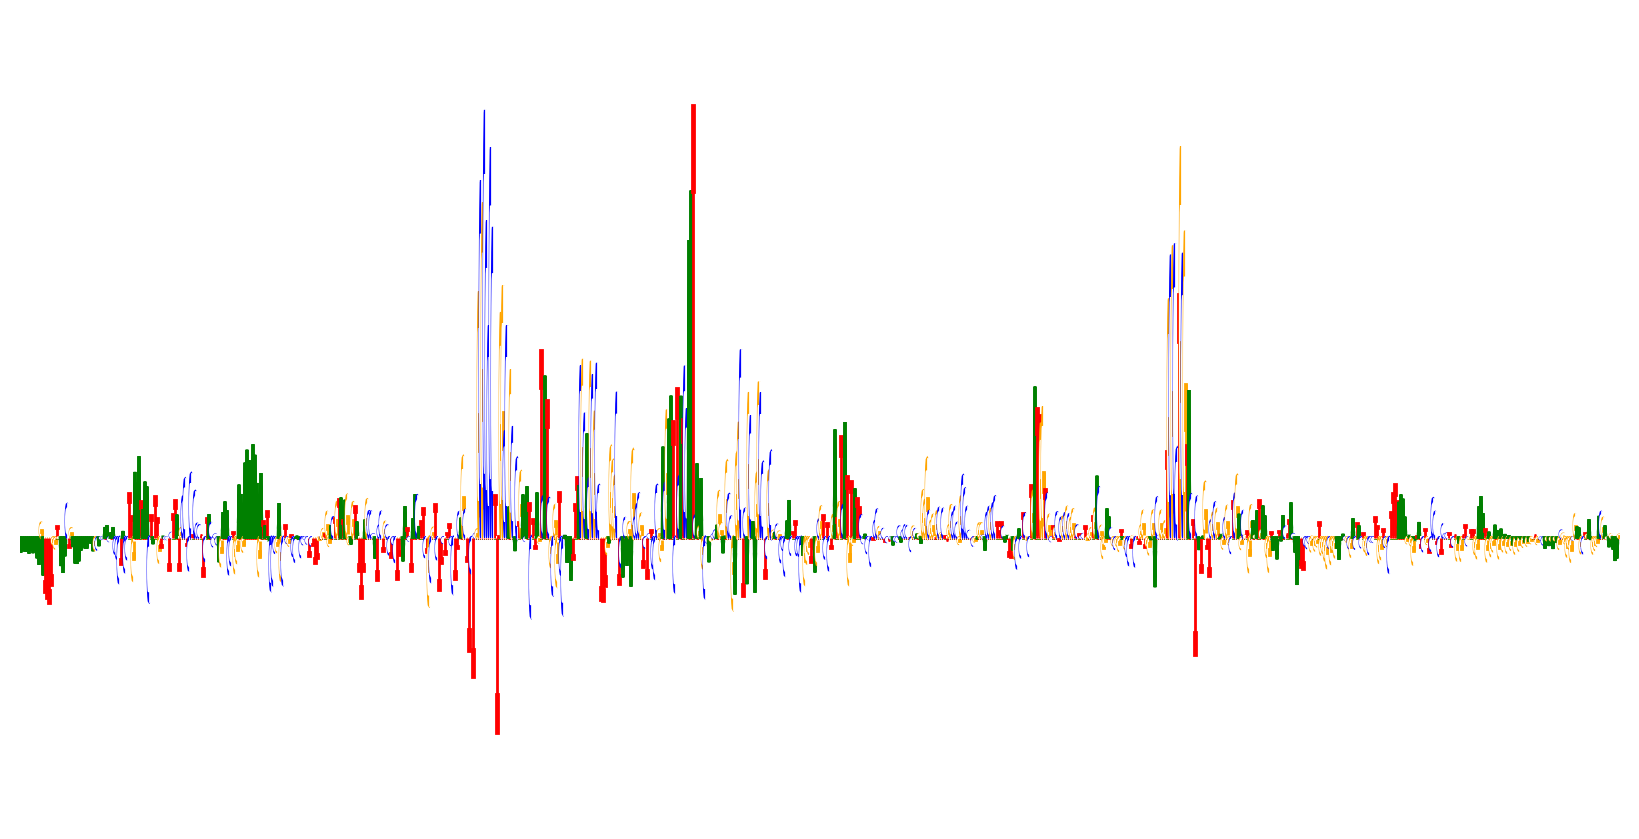

In [17]:
# Plot as ACTG letter track
fig, ax  = plt.subplots(dpi = 200, figsize = (8, 4))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ohe = one_hot_encoding[example_ind]
scp.plotting_seq.plot_weights_given_ax(
    ax = ax,
    array = (attr * ohe)[:, :],
    height_padding_factor=0.2,
    length_padding=0.0,)
ax.axis('off')
plt.savefig(os.path.join(plot_dir, region_id + "_attribution_letter_track.png"), dpi=300)

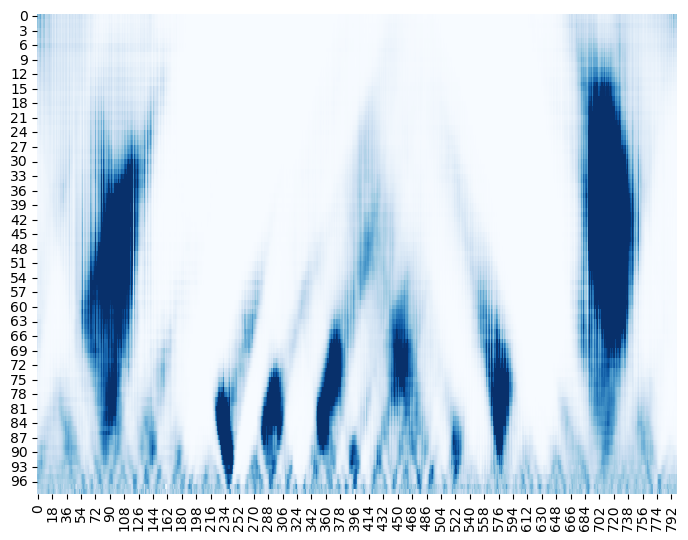

In [18]:
# Visualize predicted footprints of a specific region
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax = sns.heatmap(pred_footprints_avg[example_ind][::-1], cmap='Blues', vmin=0.0, vmax=0.5, cbar=False)
plt.savefig(os.path.join(plot_dir, region_id + "_predicted_multiscale_footprints.png"), dpi=300)

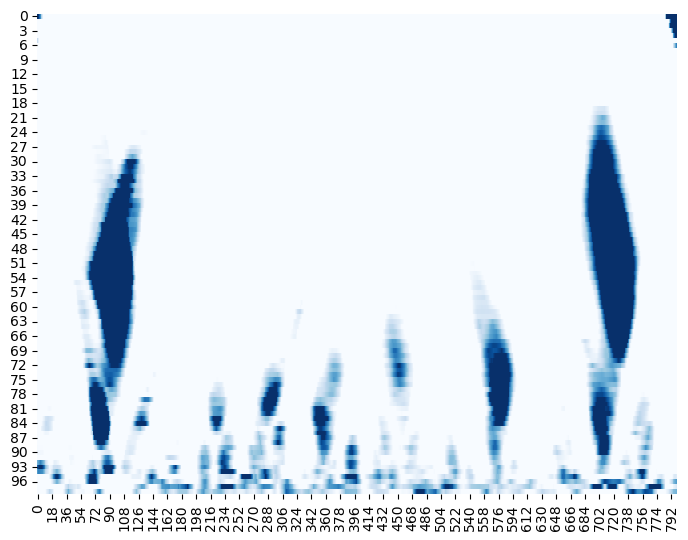

In [19]:
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax = sns.heatmap(gt_footprints[example_ind][::-1], cmap='Blues', vmin=0.5, vmax=2.0, cbar=False)
plt.savefig(os.path.join(plot_dir, region_id + "_multiscale_footprints.png"), dpi=300)

In [20]:
sys.path.append("/home/yanhu/data/PRINT/multiScaleFootprinting/code")
import scprinter as scp
from scprinter.seq.attributions import *
from scprinter.seq.attribution_wrapper import *

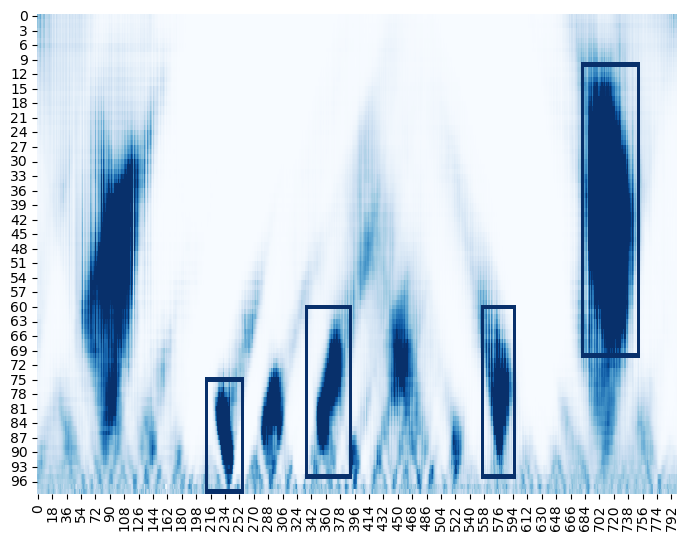

In [31]:
# Draw boxes for each footprint we want to examine, provide xmin, xmax, ymin, ymax
footprint_boxes = [[210,255,2,25], [335,390,5,40], [555,600,5,40], [680,750,30,90]]
plot_mtx = np.flip(copy.deepcopy(pred_footprints_avg[example_ind][::-1]), axis=0)
for box in footprint_boxes:
    xmin, xmax, ymin, ymax = box
    plot_mtx[(ymin - 2):(ymax - 1), xmin:(xmin + 3)] = 1
    plot_mtx[(ymin - 2):(ymax - 1), xmax:(xmax + 3)] = 1
    plot_mtx[ymin - 2, xmin:(xmax + 1)] = 1
    plot_mtx[ymax - 2, xmin:(xmax + 1)] = 1
plot_mtx = np.flip(plot_mtx, axis=0) 

# Visualize predicted footprints of a specific region
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax = sns.heatmap(plot_mtx, cmap='Blues', vmin=0.0, vmax=0.5, cbar=False)
plt.savefig(os.path.join(plot_dir, region_id + "_predicted_multiscale_footprints_with_box.png"), dpi=300)

In [45]:
attrs = 0

# Specify a target region and scale range to calculate attribution score for
# The start and end positions are relative to the 1-800 bp output footprint map, not the 1840 bp input sequence
target_pos_start = 210
target_pos_end = 255
target_scale_start = 2
target_scale_end = 25 # Inclusive
flank = 920

# We don't have 0bp and 1bp dispersion models, so 1st output is 2bp
# If we want 2bp to 30bp scales (including 30), we need the 1st to 29th outputs
# Which corresponds to np.arange(0, 29)
target_dim_ind_start = target_scale_start - 2
target_dim_ind_end = target_scale_end - 2 + 1

# Extract genomic sequence of the current locus
chr, s, e = chrs[example_ind], starts[example_ind], ends[example_ind]
center = (s + e) // 2
seq = scp.genome.hg38.fetch_seq(chr, center-flank, center+flank)

# One-hot encoding
seq_onehot = scp.utils.DNA_one_hot(seq)[None].float().cuda()

# Calculate sequence attribution scores
for m in models:
    m = m.cpu()
    wrapper = JustSumWrapper(m, specific_pos=torch.arange(target_pos_start, target_pos_end), 
                             nth_output=torch.arange(target_dim_ind_start, target_dim_ind_end), 
                             res=1, threshold=0.301).cuda()
    attributions = calculate_attributions(wrapper,
                                          X=seq_onehot.cpu(),
                                          n_shuffles=20,
                                          method='shap_hypo', verbose=False)
    attrs += (attributions.cpu() * seq_onehot.cpu())[0].detach().cpu().numpy()[:, 520:-520]

# Calcuate average attribution across ATCG and across models
attrs = attrs.sum(axis=0) / len(models)

2024-02-27 10:14:57 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-27 10:14:57 - INFO - maxp pruned
2024-02-27 10:14:57 - INFO - cmap pruned
2024-02-27 10:14:57 - INFO - kern dropped
2024-02-27 10:14:58 - INFO - post pruned
2024-02-27 10:14:58 - INFO - FFTM dropped
2024-02-27 10:14:58 - INFO - GPOS pruned
2024-02-27 10:14:58 - INFO - GSUB pruned
2024-02-27 10:14:58 - INFO - glyf pruned
2024-02-27 10:14:58 - INFO - Added gid0 to subset
2024-02-27 10:14:58 - INFO - Added first four glyphs to subset
2024-02-27 10:14:58 - INFO - Closing glyph list over 'GSUB': 13 glyphs before
2024-02-27 10:14:58 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
2024-02-27 10:14:58 - INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27]
2024-02-27 10:14:58 - INFO - Closed

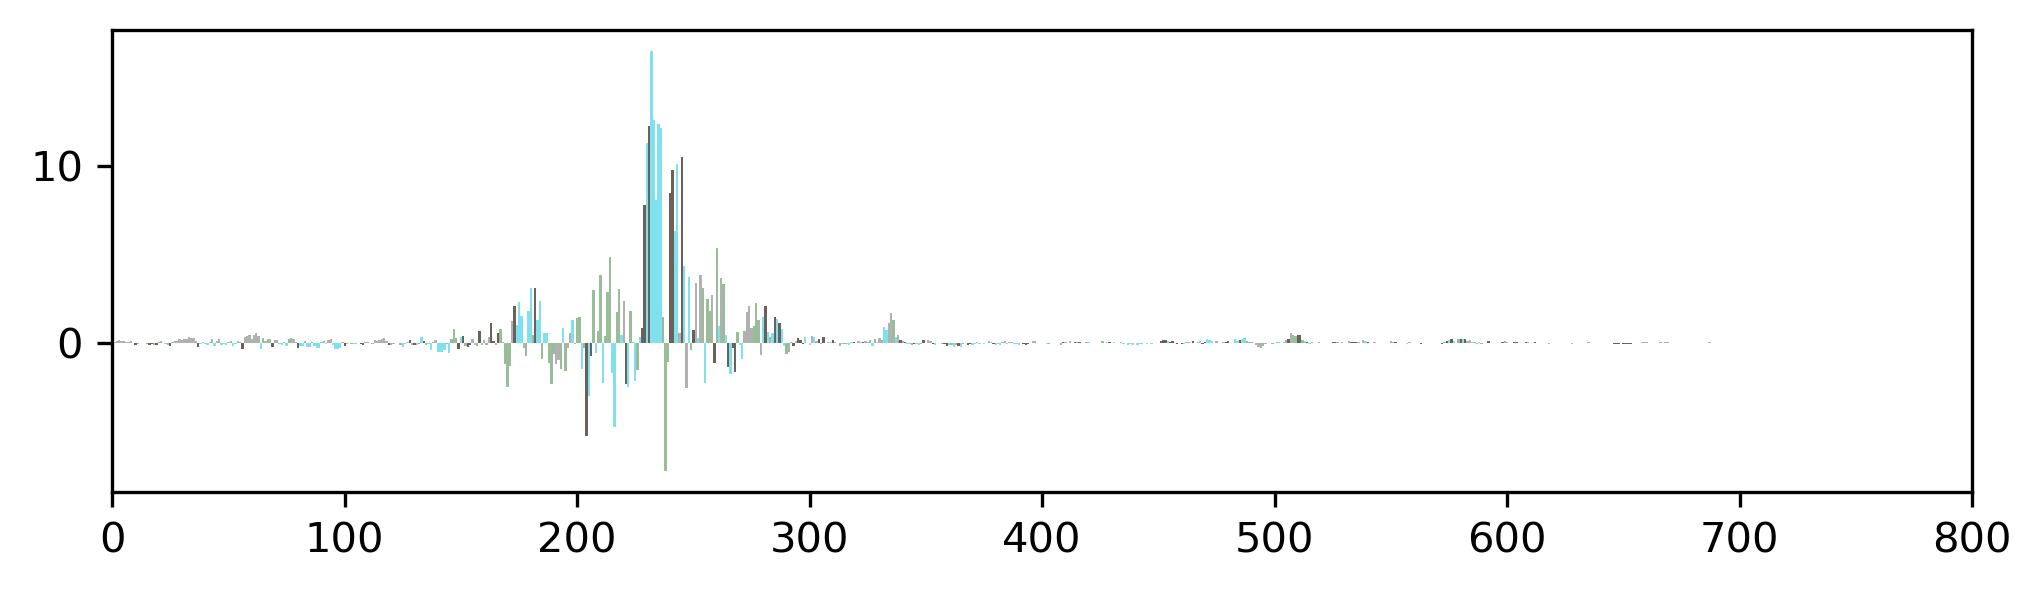

In [46]:
fig, ax_  = plt.subplots(dpi = 300, figsize = (8, 2))
x = np.arange(len(attrs))
color = [["#b2b1b1", "#7fe0ee", "#6b615a", "#99bd98"][i] for i in np.argmax(seq_onehot[0, :, 520:-520].cpu(), axis=0)]
ax_.bar(x=x, height=attrs, width=1,color=color)
ax.legend()
ax_.set_xlim(0, attrs.shape[-1])
plt.savefig(os.path.join(plot_dir, region_id + "_attribution_score_region_" + \
                         str(target_pos_start) + "_" + str(target_pos_end) + "_scale_" +\
                         str(target_scale_start) + "_" + str(target_scale_end) + ".pdf"), dpi = 200)

## Subfigure - 3: Bound vs Unbound Seq attr (Analysis)

In [102]:
def read_TF_loci(path):
    TF_sites = pd.read_csv(path, sep='\t')
    if 'range' in TF_sites.columns:
        ranges = pd.DataFrame([re.split(':|-', xx) for xx in TF_sites['range']])
        ranges = ranges[[0,1,2,3]]
        v = np.array(ranges[3])
        v[v == ''] = '-'
        ranges[3] = v
        ranges.columns = ['chrom','start','end', 'strand']
        ranges['start'] = ranges['start'].astype('int')
        ranges['end'] = ranges['end'].astype('int')
        TF_sites = pd.concat([TF_sites, ranges], axis=1)
    else:
        TF_sites = pd.read_csv(path, sep='\t', header=None)
        TF_sites.columns = ['chrom','start','end', 'bound', 'TF']
    # TF_sites = TF_sites.sort_values(by=['bound'], ascending=False) # sort such that bound = 1, comes first, and will be kept.
    TF_sites['summit'] = (TF_sites['start'] + TF_sites['end']) // 2
    return TF_sites

In [103]:
TFBS = read_TF_loci(TFBS_path)
TFs = TFBS['TF'].unique()

In [20]:
bwpath = [os.path.join(model_dir, model+"_deepshap", "attr.just_sum.shap_hypo_0-30_.None.bigwig") for model in models_path] 
bw = [pyBigWig.open(path, 'r') for path in bwpath]
TF2results = {}
for TF in TFs:
    dfs = TFBS.copy()
    dfs = dfs[dfs['TF'] == TF].reset_index()
    dfs['mid'] = (dfs['start'].astype('int') + dfs['end'].astype('int')) // 2
    vs = []
    select = []
    for chrom,start,end in zip(tqdm(dfs['chrom']), dfs['mid']-100, dfs['mid']+100):
        v = [bw_.values(chrom, int(start), int(end), numpy=True) for bw_ in bw]
        v = np.array(v).mean(axis=0)
        vs.append(v)
        select.append(True)
    select = np.array(select)
    vs = np.array(vs)
    dfs = dfs.loc[np.array(select)]
    label = np.array(dfs['bound'])
    bound = vs[label == 1]
    order = np.argsort(bound[:, 100])[::-1]
    bound = bound[order]
    
    unbound = vs[label == 0]
    if len(unbound) > len(bound) * 2:
        unbound = unbound[np.random.permutation(len(unbound))[:int(len(bound) * 2)]]
    order = np.argsort(unbound[:, 100])[::-1]
    unbound = unbound[order]
    
    vmax = np.quantile(vs, 0.99)
    TF2results[TF] = [bound, unbound, vmax]

  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/10125 [00:00<?, ?it/s]

  0%|          | 0/7502 [00:00<?, ?it/s]

  0%|          | 0/8499 [00:00<?, ?it/s]

  0%|          | 0/20661 [00:00<?, ?it/s]

  0%|          | 0/16862 [00:00<?, ?it/s]

  0%|          | 0/10062 [00:00<?, ?it/s]

  0%|          | 0/4304 [00:00<?, ?it/s]

  0%|          | 0/4618 [00:00<?, ?it/s]

  0%|          | 0/55959 [00:00<?, ?it/s]

  0%|          | 0/10162 [00:00<?, ?it/s]

  0%|          | 0/17592 [00:00<?, ?it/s]

  0%|          | 0/10220 [00:00<?, ?it/s]

  0%|          | 0/6769 [00:00<?, ?it/s]

  0%|          | 0/31893 [00:00<?, ?it/s]

  0%|          | 0/38047 [00:00<?, ?it/s]

  0%|          | 0/30979 [00:00<?, ?it/s]

  0%|          | 0/12747 [00:00<?, ?it/s]

  0%|          | 0/9826 [00:00<?, ?it/s]

  0%|          | 0/31423 [00:00<?, ?it/s]

  0%|          | 0/46355 [00:00<?, ?it/s]

  0%|          | 0/26281 [00:00<?, ?it/s]

  0%|          | 0/30073 [00:00<?, ?it/s]

  0%|          | 0/19119 [00:00<?, ?it/s]

  0%|          | 0/22723 [00:00<?, ?it/s]

  0%|          | 0/9651 [00:00<?, ?it/s]

  0%|          | 0/10408 [00:00<?, ?it/s]

  0%|          | 0/13805 [00:00<?, ?it/s]

  0%|          | 0/25510 [00:00<?, ?it/s]

  0%|          | 0/28155 [00:00<?, ?it/s]

  0%|          | 0/9140 [00:00<?, ?it/s]

  0%|          | 0/16514 [00:00<?, ?it/s]

  0%|          | 0/30907 [00:00<?, ?it/s]

  0%|          | 0/20116 [00:00<?, ?it/s]

  0%|          | 0/10546 [00:00<?, ?it/s]

  0%|          | 0/13018 [00:00<?, ?it/s]

  0%|          | 0/26472 [00:00<?, ?it/s]

  0%|          | 0/25268 [00:00<?, ?it/s]

  0%|          | 0/17741 [00:00<?, ?it/s]

  0%|          | 0/17745 [00:00<?, ?it/s]

  0%|          | 0/17767 [00:00<?, ?it/s]

  0%|          | 0/20636 [00:00<?, ?it/s]

  0%|          | 0/9875 [00:00<?, ?it/s]

  0%|          | 0/15508 [00:00<?, ?it/s]

  0%|          | 0/14918 [00:00<?, ?it/s]

  0%|          | 0/16613 [00:00<?, ?it/s]

In [21]:
pickle.dump(TF2results, 
            open(os.path.join(model_dir, "Fig2_data2.pkl"), "wb"))

## Subfigure - 3: Bound vs Unbound Seq attr (Visualization)

In [77]:
TFBS = read_TF_loci(TFBS_path)
TFs = TFBS['TF'].unique()

In [78]:
TF2results = pickle.load(open(os.path.join(model_dir, "Fig2_data2.pkl"), "rb"))

In [139]:
outdir = os.path.join(plot_dir, "bound_vs_unbound")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [83]:
# now for making clean figures, make sure to change the name
for TF in TFs:
    bound, unbound, vmax = TF2results[TF]
    print(TF, vmax)
    fig = plt.figure(figsize=(2.5, 6))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    sns.heatmap(unbound, cmap='Blues',  vmin=0, vmax=vmax, cbar=False)
    plt.axis('off')
    plt.savefig(os.path.join(outdir, TF + "_unbound_seq.png"), dpi=300)
    plt.close('all')
    fig = plt.figure(figsize=(2.5, 6))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    sns.heatmap(bound, cmap='Blues',  vmin=0, vmax=vmax, cbar=False)
    plt.axis('off')
    plt.savefig(os.path.join(outdir, TF + "_bound_seq.png"), dpi=300)
    plt.close('all')
    # break

ATF2 39.10799579620362
ATF3 39.48231208801271
ATF7 37.31121883392338
BHLHE40 34.2894865036011
CEBPA 31.345704689025844
CEBPB 35.14191154479978
CEBPG 40.50153968811037
CREB1 45.671960144042984
CREM 45.605979995727544
CTCF 94.28899589538553
ELF1 43.78297424316406
ELF3 23.11493635177609
ETV4 43.70313777923586
ETV5 54.89394214630129
FOSL2 31.200185775756836
FOXA2 29.47088729858396
FOXA3 27.870641994476312
GABPA 48.296791076660156
HLF 26.90065954208376
HNF1A 37.22274532318087
HNF4G 32.24480850219717
JUN 30.75663450241083
JUND 31.078372955322266
MAFF 22.252001457214256
MAFK 21.993934574126985
MAX 24.949104156494148
MLX 28.766066741943362
MXI1 26.447299880980935
NFE2L2 23.705904712676944
NFIA 31.56542499542234
NFIL3 27.91161104202272
NFYC 34.63583164215067
NR2F2 24.982266235351545
NRF1 95.3421630859375
RFX1 26.940185546875
RFX3 28.668981552124023
RXRA 28.98630632400506
RXRB 28.222403831481905
SRF 17.704818725585938
TCF7 24.559061164855827
TEAD3 19.566059379577545
TEAD4 22.154253425598093
TFE3

## Subfigure - 4: Bound vs Unbound Footprints

In [141]:
TFBS = read_TF_loci(TFBS_path)
TFs = TFBS['TF'].unique()

In [142]:
for TF in TFs:

    print("Calculating footprints for " + TF)

    # Retrieve motif sites of the current TF
    sites = TFBS.loc[TFBS["TF"] == TF, :]
    site_keys = [f'{row["chrom"]}:{row["summit"] - 100}-{row["summit"] + 100}' for i, row in sites.iterrows()]
    
    # Calculate observed footprints
    scp.tl.get_footprint_score(printer=printer,
                               cell_grouping = printer.insertion_file.obs_names,
                               group_names = 'HepG2',
                               regions = site_keys,
                               modes = 20, 
                               nCores = 16,
                               backed = False,
                               overwrite = True)
    sites_footprints = np.array([printer.footprintsadata['FootPrints'].obsm[k] for k in site_keys])
    sites_footprints = np.squeeze(sites_footprints)
    
    # Split results into bound/unbound based on overlap with ChIP
    bound_footprints = sites_footprints[sites["bound"] == 1, :]
    unbound_footprints = sites_footprints[sites["bound"] == 0, :]
    
    # Re-order sites by footprint signal at the motif center
    order = np.argsort(bound_footprints[:, 100])[::-1]
    bound_footprints = bound_footprints[order, :]
    order = np.argsort(unbound_footprints[:, 100])[::-1]
    unbound_footprints = unbound_footprints[order, :]
    
    # Visualize footprints at bound sites
    vmax = np.quantile(sites_footprints, 0.99)
    fig = plt.figure(figsize=(2.5, 6))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    sns.heatmap(bound_footprints, cmap='Blues',  vmin=0, vmax=vmax, cbar=False)
    plt.axis('off')
    plt.savefig(os.path.join(outdir, TF + "_bound_footprint.png"), dpi=300)
    plt.close('all')
    
    # Visualize footprints at unbound sites
    fig = plt.figure(figsize=(2.5, 6))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    sns.heatmap(unbound_footprints, cmap='Blues',  vmin=0, vmax=vmax, cbar=False)
    plt.axis('off')
    plt.savefig(os.path.join(outdir, TF + "_unbound_footprint.png"), dpi=300)
    plt.close('all')

Calculating footprints for ATF2
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/6762 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/6762 [00:00<?, ?it/s]

Calculating footprints for ATF3
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/10125 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/10125 [00:00<?, ?it/s]

Calculating footprints for ATF7
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/7502 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/7502 [00:00<?, ?it/s]

Calculating footprints for BHLHE40
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/8499 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/8499 [00:00<?, ?it/s]

Calculating footprints for CEBPA
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/20661 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/20661 [00:00<?, ?it/s]

Calculating footprints for CEBPB
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/16862 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/16862 [00:00<?, ?it/s]

Calculating footprints for CEBPG
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/10062 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/10062 [00:00<?, ?it/s]

Calculating footprints for CREB1
estimated file size: 0.00 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/4304 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/4304 [00:00<?, ?it/s]

Calculating footprints for CREM
estimated file size: 0.00 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/4618 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/4618 [00:00<?, ?it/s]

Calculating footprints for CTCF
estimated file size: 0.04 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/55959 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/55959 [00:00<?, ?it/s]

Calculating footprints for ELF1
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/10162 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/10162 [00:00<?, ?it/s]

Calculating footprints for ELF3
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/17592 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/17592 [00:00<?, ?it/s]

Calculating footprints for ETV4
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/10220 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/10220 [00:00<?, ?it/s]

Calculating footprints for ETV5
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/6769 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/6769 [00:00<?, ?it/s]

Calculating footprints for FOSL2
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/31893 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/31893 [00:00<?, ?it/s]

Calculating footprints for FOXA2
estimated file size: 0.03 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/38047 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/38047 [00:00<?, ?it/s]

Calculating footprints for FOXA3
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/30979 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/30979 [00:00<?, ?it/s]

Calculating footprints for GABPA
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/12747 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/12747 [00:00<?, ?it/s]

Calculating footprints for HLF
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/9826 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/9826 [00:00<?, ?it/s]

Calculating footprints for HNF1A
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/31423 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/31423 [00:00<?, ?it/s]

Calculating footprints for HNF4G
estimated file size: 0.03 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/46355 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/46355 [00:00<?, ?it/s]

Calculating footprints for JUN
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/26281 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/26281 [00:00<?, ?it/s]

Calculating footprints for JUND
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/30073 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/30073 [00:00<?, ?it/s]

Calculating footprints for MAFF
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/19119 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/19119 [00:00<?, ?it/s]

Calculating footprints for MAFK
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/22723 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/22723 [00:00<?, ?it/s]

Calculating footprints for MAX
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/9651 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/9651 [00:00<?, ?it/s]

Calculating footprints for MLX
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/10408 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/10408 [00:00<?, ?it/s]

Calculating footprints for MXI1
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/13805 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/13805 [00:00<?, ?it/s]

Calculating footprints for NFE2L2
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/25510 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/25510 [00:00<?, ?it/s]

Calculating footprints for NFIA
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/28155 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/28155 [00:00<?, ?it/s]

Calculating footprints for NFIL3
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/9140 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/9140 [00:00<?, ?it/s]

Calculating footprints for NFYC
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/16514 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/16514 [00:00<?, ?it/s]

Calculating footprints for NR2F2
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/30907 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/30907 [00:00<?, ?it/s]

Calculating footprints for NRF1
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/20116 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/20116 [00:00<?, ?it/s]

Calculating footprints for RFX1
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/10546 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/10546 [00:00<?, ?it/s]

Calculating footprints for RFX3
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/13018 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/13018 [00:00<?, ?it/s]

Calculating footprints for RXRA
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/26472 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/26472 [00:00<?, ?it/s]

Calculating footprints for RXRB
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/25268 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/25268 [00:00<?, ?it/s]

Calculating footprints for SRF
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/17741 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/17741 [00:00<?, ?it/s]

Calculating footprints for TCF7
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/17745 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/17745 [00:00<?, ?it/s]

Calculating footprints for TEAD3
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/17767 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/17767 [00:00<?, ?it/s]

Calculating footprints for TEAD4
estimated file size: 0.02 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/20636 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/20636 [00:00<?, ?it/s]

Calculating footprints for TFE3
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/9875 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/9875 [00:00<?, ?it/s]

Calculating footprints for USF1
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/15508 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/15508 [00:00<?, ?it/s]

Calculating footprints for USF2
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/14918 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/14918 [00:00<?, ?it/s]

Calculating footprints for YY1
estimated file size: 0.01 GB
Creating FootPrints in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/16613 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/16613 [00:00<?, ?it/s]

## Subfigure - 5: Multi-scale sequence attribution scores

In [231]:
chr, s, e = chrs[example_ind], starts[example_ind], ends[example_ind]
regions = [f'{chr}:{s}-{e}']

In [232]:
from scprinter.seq.attribution_helper import _multiscale_ism_l2

# Calculate sequence attribution scores using in-silico mutagenesis
ism_scores = []
for m in models:
    ism_scores.append(
        scp.seq.attribution_helper.multiscale_ism(m,
                       printer,
                       regions,
                       scales=np.arange(99),
                       scale_group_size=1,
                       effect_range=None,
                       attr_reduce_mean=True,
                       mutate_positions=None,
                       verbose=False,
                       project=True,
                       sum=True,
                       batch_size=64,))
ism_scores = np.squeeze(np.array(ism_scores))
ism_scores = np.flip(np.mean(ism_scores, axis=0), axis=0)
ism_scores = ism_scores[:, 520:-520]

<Axes: >

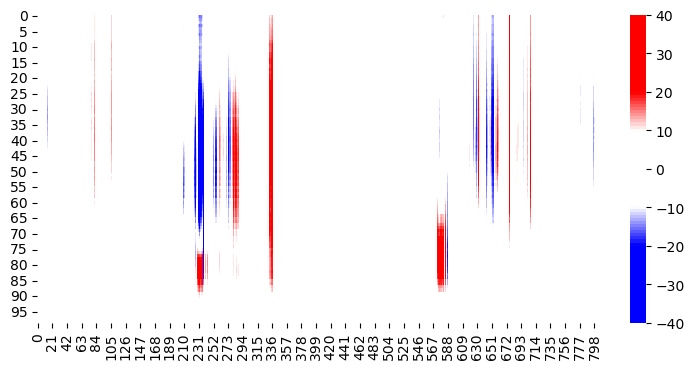

In [283]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["Blue"] * 1 + ["White"] * 3 + ["Red"] * 1  # Blue to white to red
cm = LinearSegmentedColormap.from_list("blue_red", colors, N=100)
plt.subplots(figsize=(9,4))
sns.heatmap(ism_scores, cmap=cm, vmin=-40, vmax=40)

In [106]:
printer.close()

In [288]:
import random

# Get model-predictdd multi-scale footprints for the sampled regions
pred_footprints_avg = 0
pred_coverage_avg = 0
chr, s, e = "chr4", 39181839, 39182839
center = (s + e) // 2
site_left_boundary = 340
site_right_boundary = 380
flank = 920
mutate_site = True
with torch.no_grad():
    for model in models:
        model = model.cuda()
        # Now from model predictions
        seq = scp.genome.hg38.fetch_seq(chr, center-flank, center+flank)
        if mutate_site:
            seq = list(seq)
            site_left_boundary = site_left_boundary + (flank - 400)
            site_right_boundary = site_right_boundary + (flank - 400)
            seq[site_left_boundary:site_right_boundary] = random.choices('ACGT', k=site_right_boundary - site_left_boundary)
            seq = "".join(seq)
        seq = scp.utils.DNA_one_hot(seq)[None].float().cuda()
        pred_footprint, pred_coverage = model(seq)
        pred_footprints_avg += np.array(pred_footprint.cpu())
        model = model.cpu()
pred_footprints_avg /= len(models)
pred_footprints_avg = scp.utils.zscore2pval(np.squeeze(pred_footprints_avg))
pred_footprints_avg = np.flip(pred_footprints_avg, axis=0)

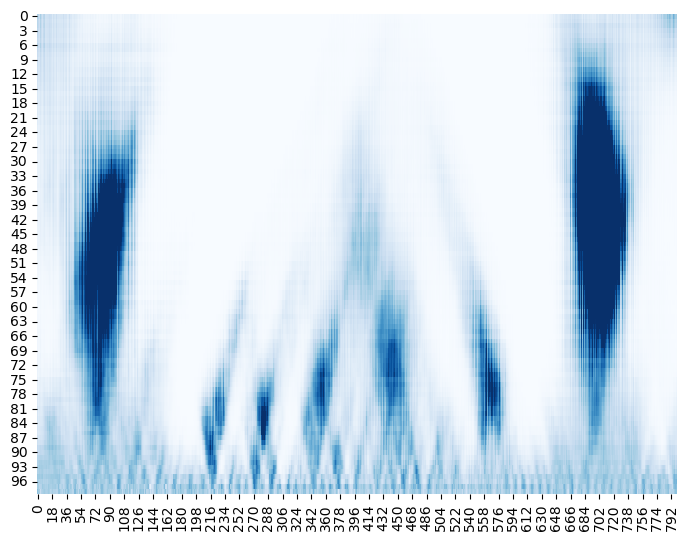

In [289]:
# Visualize predicted footprints of a specific region
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax = sns.heatmap(pred_footprints_avg, cmap='Blues', vmin=0.0, vmax=0.5, cbar=False)

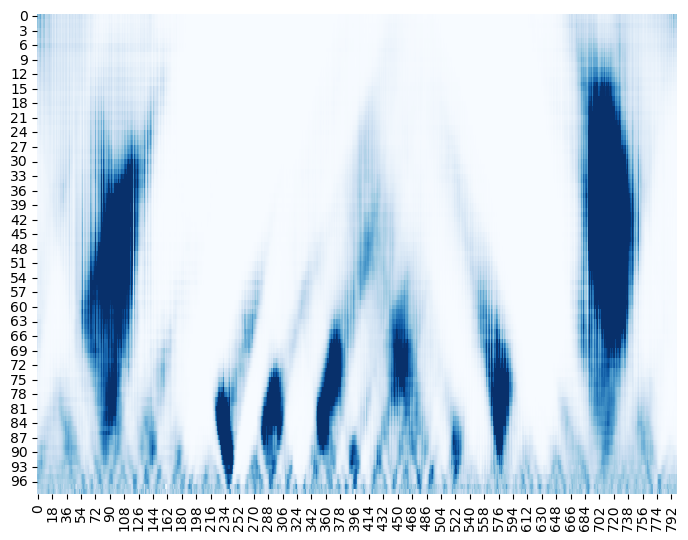

In [246]:
# Visualize predicted footprints of a specific region
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax = sns.heatmap(pred_footprints_avg, cmap='Blues', vmin=0.0, vmax=0.5, cbar=False)